In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')

%run '../functions.py'
%run '../classes.py'

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/adammajczyk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/adammajczyk/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/adammajczyk/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/adammajczyk/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/adammajczyk/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/adammajczyk/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/adammajczyk/nltk_data..

In [79]:
save_path = 'grid_search_results_new.json'
grids_path = '../grid_search_grids.json'

In [80]:
model_w2v_settings = return_best_model()

In [81]:
model_w2v = Word2VecModel(model_w2v_settings)

In [82]:
# read preprocessed data from pickle file
df = pd.read_pickle('data/preprocessed_titles_labels.pkl')
df.head()

,title,is_clickbait,text,dataset,sample
0,"[seventeen, time, game, throne, matched, perfe...",1,NaN,clickbait-dataset,train
1,"[facing, texas, tar, heel, territory, duke, fi...",0,NaN,clickbait-dataset,train
4,"[wikinews, interview, kevin, baugh, president,...",0,NaN,clickbait-dataset,train
6,"[identify, justin, bieber, music, video, youtu...",1,NaN,clickbait-dataset,train
9,"[uganda, introduces, antihomosexual, legislation]",0,NaN,clickbait-dataset,train


In [83]:
df['sample'].value_counts()


sample
train    28836
test      1607
val2       781
val1       776
Name: count, dtype: int64

In [84]:
# split data into train and test stratified by y
from sklearn.preprocessing import StandardScaler
import os
import pickle

df['title_vector'] = [get_word_vectors(model_w2v, title, aggregation='mean') for title in df['title']]
df = df.reset_index(drop=True)
df.head()

,title,is_clickbait,text,dataset,sample,title_vector
0,"[seventeen, time, game, throne, matched, perfe...",1,NaN,clickbait-dataset,train,"[-0.35697305, 0.060773212, -0.14922297, 1.3295..."
1,"[facing, texas, tar, heel, territory, duke, fi...",0,NaN,clickbait-dataset,train,"[0.07802807, -0.04521935, -0.052836318, 0.3131..."
2,"[wikinews, interview, kevin, baugh, president,...",0,NaN,clickbait-dataset,train,"[1.0316621, 0.07722468, -0.7290555, -0.7217082..."
3,"[identify, justin, bieber, music, video, youtu...",1,NaN,clickbait-dataset,train,"[0.30820984, -0.27304775, 0.35161975, 0.784931..."
4,"[uganda, introduces, antihomosexual, legislation]",0,NaN,clickbait-dataset,train,"[0.80752313, -0.063545935, -0.43700808, 0.3999..."


In [85]:
df['title_vector'][0]

array([-0.35697305,  0.06077321, -0.14922297,  1.3295176 ,  0.5311293 ,
        0.31932646,  0.01412213,  0.16840689, -0.8577355 , -0.14037684,
       -0.13358489, -0.2855721 ,  0.13571858, -0.16594379,  1.3013978 ,
        0.71673936,  0.24522454, -0.29494774, -0.8973892 , -0.18755664],
      dtype=float32)

In [86]:
variables_to_drop = get_dimensions_to_drop()
variables_to_drop

[9, 12, 19, 0, 4, 6, 14]

In [87]:
df['title_vector'] = [drop_dimensions_from_vector(vector, variables_to_drop) for vector in df['title_vector']]

In [88]:
df['title_vector'][0]

array([ 0.06077321, -0.14922297,  1.3295176 ,  0.31932646,  0.16840689,
       -0.8577355 , -0.13358489, -0.2855721 , -0.16594379,  0.71673936,
        0.24522454, -0.29494774, -0.8973892 ], dtype=float32)

In [89]:
X_train = np.vstack(df[df['sample']=='train']['title_vector'])
X_test = np.vstack(df[df['sample']=='val2']['title_vector'])

y_train = df[df['sample']=='train']['is_clickbait']
y_test = df[df['sample']=='val2']['is_clickbait']

# scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [90]:
import json

with open(grids_path, 'r') as f:
    model_settings = json.load(f)

model_settings
grids = model_settings['grid_search_grids']
grids

{'decision_tree_grid': {'max_depth': [None, 3, 4, 5, 6, 7, 8],
  'max_features': ['sqrt', 'log2', None]},
 'catboost_grid': {'iterations': [100, 250, 500],
  'learning_rate': [None, 0.001, 0.01, 0.1, 0.2, 0.3],
  'depth': [3, 4, 5, 6, 7, 8],
  'l2_leaf_reg': [1, 3, 5, 7, 9]},
 'lightgbm_grid': {'n_estimators': [50, 100, 250, 500],
  'learning_rate': [None, 0.01, 0.1, 0.2, 0.3],
  'max_depth': [-1, 3, 4, 5, 6, 7, 8],
  'num_leaves': [15, 31, 62, 93, 124, 155, 187, 217]},
 'xgboost_grid': {'n_estimators': [10, 25, 50, 100, 250],
  'learning_rate': [None, 0.001, 0.01, 0.1, 0.2, 0.3],
  'max_depth': [None, 3, 4, 5, 6, 7, 8],
  'gamma': [0, 0.01, 0.1, 0.5, 1, 5]},
 'random_forest_grid': {'n_estimators': [50, 100, 250, 500],
  'max_depth': [None, 3, 4, 5, 6, 7, 8],
  'max_features': ['sqrt', 'log2', None]}}

In [91]:
models_to_CV = list()

for model_name, grid in grids.items():
    # check if model has already been trained - if 'best_params' exists in grid
    if 'best_params' in grid.keys():
        print(f'Model {model_name} already trained')
        continue
    models_to_CV.append((model_name))
models_to_CV

# remove _grid from model names
models_to_CV = [model_name.replace('_grid', '') for model_name in models_to_CV]
models_to_CV

['decision_tree', 'catboost', 'lightgbm', 'xgboost', 'random_forest']

In [92]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [93]:
def return_model_with_param(model_name, param = dict()):
    if model_name == 'decision_tree':
        model = DecisionTreeClassifier(**param)
    elif model_name == 'random_forest':
        model = RandomForestClassifier(**param)
    elif model_name == 'xgboost':
        model = XGBClassifier(**param)
    elif model_name == 'lightgbm':
        model = LGBMClassifier(**param, verbose=-1)
    elif model_name == 'catboost':
        model = CatBoostClassifier(**param,verbose=0)
    return model

In [94]:
models_to_CV = [
    'xgboost',
    'lightgbm', 
    'decision_tree', 
    'random_forest',  
    'catboost'
]

In [95]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score
from tqdm.notebook import tqdm

# read existing results
try:
    with open(save_path, 'r') as f:
        grid_search_results = json.load(f)
    print('Loaded existing results')
except:
    grid_search_results = dict()
    print('No existing results found - creating new dict')
for model_name in models_to_CV:
    grid_search_results[model_name] = dict()

for model_name in tqdm(models_to_CV, desc = 'Models'):

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # get grid
    grid = grids[model_name+'_grid']

    # generate all combinations of parameters
    import itertools

    keys, values = zip(*grid.items())
    combinations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # do grid search
    
    for params in combinations_dicts:
        grid_search_results[model_name][str(params)] = dict()

    for params in tqdm(combinations_dicts, desc = 'Grid combinations search for model {}'.format(model_name)):
       
        model = return_model_with_param(model_name, params)
        scores_auc_cv_val = list()
        scores_auc_val2 = list()
        scores_auc_train = list()

        scores_f1_cv_val = list()
        scores_f1_val2 = list()
        scores_f1_train = list()

        for train_index, val_index in kf.split(X_train_scaled, y_train):
            X_train_kf = X_train_scaled[train_index]
            X_val_kf = X_train_scaled[val_index]
            y_train_kf = y_train.iloc[train_index]
            y_val_kf = y_train.iloc[val_index]

            model.fit(X_train_kf, y_train_kf)

            # print(model)

        
            scores_auc_cv_val.append(roc_auc_score(y_val_kf, model.predict_proba(X_val_kf)[:,1]))
            scores_auc_val2.append(roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:,1]))
            scores_auc_train.append(roc_auc_score(y_train_kf, model.predict_proba(X_train_kf)[:,1]))

            y_pred_cv_val = model.predict_proba(X_val_kf)[:,1]
            y_pred_val2 = model.predict_proba(X_test_scaled)[:,1]
            y_pred_train = model.predict_proba(X_train_kf)[:,1]

            # print(y_pred_cv_val[y_pred_cv_val>0.5])

            y_pred_cv_val = np.where(y_pred_cv_val > 0.5, 1, 0)
            y_pred_val2 = np.where(y_pred_val2 > 0.5, 1, 0)
            y_pred_train = np.where(y_pred_train > 0.5, 1, 0)


            
            scores_f1_cv_val.append(f1_score(y_val_kf, model.predict(X_val_kf)))
            scores_f1_val2.append(f1_score(y_test, model.predict(X_test_scaled)))
            scores_f1_train.append(f1_score(y_train_kf, model.predict(X_train_kf)))
            break

        # print(scores_f1_train, scores_f1_cv_val, scores_f1_val2)
        # print(scores_auc_train, scores_auc_cv_val, scores_auc_val2)

        grid_search_results[model_name][str(params)]['mean_train_f1'] = np.mean(scores_f1_train)
        grid_search_results[model_name][str(params)]['mean_cv_val_f1'] = np.mean(scores_f1_cv_val)
        grid_search_results[model_name][str(params)]['mean_val2_f1'] = np.mean(scores_f1_val2)

        grid_search_results[model_name][str(params)]['mean_train_auc'] = np.mean(scores_auc_train)
        grid_search_results[model_name][str(params)]['mean_cv_val_auc'] = np.mean(scores_auc_cv_val)
        grid_search_results[model_name][str(params)]['mean_val2_auc'] = np.mean(scores_auc_val2)

        grid_search_results[model_name][str(params)]['f1_diff_cv_val'] = np.mean(scores_f1_train) - np.mean(scores_f1_cv_val)
        grid_search_results[model_name][str(params)]['auc_diff_cv_val'] = np.mean(scores_auc_train) - np.mean(scores_auc_cv_val)

        grid_search_results[model_name][str(params)]['f1_diff_val2'] = np.mean(scores_f1_train) - np.mean(scores_f1_val2)
        grid_search_results[model_name][str(params)]['auc_diff_val2'] = np.mean(scores_auc_train) - np.mean(scores_auc_val2)

        grid_search_results[model_name][str(params)]['params'] = params

        # save results to json file
        with open(save_path, 'w') as f:
            json.dump(grid_search_results, f)
    



    print(grid_search_results[model_name])
    
# grid_search_results

No existing results found - creating new dict


Models:   0%|          | 0/5 [00:00<?, ?it/s]

Grid combinations search for model xgboost:   0%|          | 0/1260 [00:00<?, ?it/s]

{"{'n_estimators': 10, 'learning_rate': None, 'max_depth': None, 'gamma': 0}": {'mean_train_f1': 0.9612173913043477, 'mean_cv_val_f1': 0.9438163158810229, 'mean_val2_f1': 0.9403166869671132, 'mean_train_auc': 0.9931470136985082, 'mean_cv_val_auc': 0.9862220351974029, 'mean_val2_auc': 0.9817452488985335, 'f1_diff_cv_val': 0.017401075423324808, 'auc_diff_cv_val': 0.0069249785011052944, 'f1_diff_val2': 0.020900704337234455, 'auc_diff_val2': 0.011401764799974679, 'params': {'n_estimators': 10, 'learning_rate': None, 'max_depth': None, 'gamma': 0}}, "{'n_estimators': 10, 'learning_rate': None, 'max_depth': None, 'gamma': 0.01}": {'mean_train_f1': 0.9612173913043477, 'mean_cv_val_f1': 0.9438163158810229, 'mean_val2_f1': 0.9403166869671132, 'mean_train_auc': 0.9931470136985082, 'mean_cv_val_auc': 0.9862220351974029, 'mean_val2_auc': 0.9817452488985335, 'f1_diff_cv_val': 0.017401075423324808, 'auc_diff_cv_val': 0.0069249785011052944, 'f1_diff_val2': 0.020900704337234455, 'auc_diff_val2': 0.011

Grid combinations search for model lightgbm:   0%|          | 0/1120 [00:00<?, ?it/s]

{"{'n_estimators': 50, 'learning_rate': None, 'max_depth': -1, 'num_leaves': 15}": {'mean_train_f1': 0.9568856532542832, 'mean_cv_val_f1': 0.9448131330771917, 'mean_val2_f1': 0.9468599033816425, 'mean_train_auc': 0.9915083179565486, 'mean_cv_val_auc': 0.9873752235531041, 'mean_val2_auc': 0.9844479516012363, 'f1_diff_cv_val': 0.012072520177091484, 'auc_diff_cv_val': 0.004133094403444448, 'f1_diff_val2': 0.01002574987264071, 'auc_diff_val2': 0.007060366355312264, 'params': {'n_estimators': 50, 'learning_rate': None, 'max_depth': -1, 'num_leaves': 15}}, "{'n_estimators': 50, 'learning_rate': None, 'max_depth': -1, 'num_leaves': 31}": {'mean_train_f1': 0.965228393176563, 'mean_cv_val_f1': 0.9479366184920772, 'mean_val2_f1': 0.9501822600243013, 'mean_train_auc': 0.9945009126846387, 'mean_cv_val_auc': 0.988444070394806, 'mean_val2_auc': 0.9854606431248767, 'f1_diff_cv_val': 0.017291774684485728, 'auc_diff_cv_val': 0.00605684228983272, 'f1_diff_val2': 0.015046133152261665, 'auc_diff_val2': 0.

Grid combinations search for model decision_tree:   0%|          | 0/21 [00:00<?, ?it/s]

{"{'max_depth': None, 'max_features': 'sqrt'}": {'mean_train_f1': 1.0, 'mean_cv_val_f1': 0.9019404019404019, 'mean_val2_f1': 0.8992805755395683, 'mean_train_auc': 1.0, 'mean_cv_val_auc': 0.9018833466087559, 'mean_val2_auc': 0.891339514697179, 'f1_diff_cv_val': 0.09805959805959807, 'auc_diff_cv_val': 0.09811665339124409, 'f1_diff_val2': 0.1007194244604317, 'auc_diff_val2': 0.10866048530282102, 'params': {'max_depth': None, 'max_features': 'sqrt'}}, "{'max_depth': None, 'max_features': 'log2'}": {'mean_train_f1': 1.0, 'mean_cv_val_f1': 0.8985255854293147, 'mean_val2_f1': 0.8938271604938272, 'mean_train_auc': 1.0, 'mean_cv_val_auc': 0.8985854912156779, 'mean_val2_auc': 0.890389294403893, 'f1_diff_cv_val': 0.10147441457068529, 'auc_diff_cv_val': 0.10141450878432212, 'f1_diff_val2': 0.10617283950617284, 'auc_diff_val2': 0.10961070559610697, 'params': {'max_depth': None, 'max_features': 'log2'}}, "{'max_depth': None, 'max_features': None}": {'mean_train_f1': 1.0, 'mean_cv_val_f1': 0.90756888

Grid combinations search for model random_forest:   0%|          | 0/84 [00:00<?, ?it/s]

{"{'n_estimators': 50, 'max_depth': None, 'max_features': 'sqrt'}": {'mean_train_f1': 0.9998695028056896, 'mean_cv_val_f1': 0.9478855939638533, 'mean_val2_f1': 0.9414634146341463, 'mean_train_auc': 0.9999999736904837, 'mean_cv_val_auc': 0.9888176858684381, 'mean_val2_auc': 0.9836522654040902, 'f1_diff_cv_val': 0.051983908841836346, 'auc_diff_cv_val': 0.011182287822045556, 'f1_diff_val2': 0.05840608817154336, 'auc_diff_val2': 0.016347708286393425, 'params': {'n_estimators': 50, 'max_depth': None, 'max_features': 'sqrt'}}, "{'n_estimators': 50, 'max_depth': None, 'max_features': 'log2'}": {'mean_train_f1': 0.9999130132219902, 'mean_cv_val_f1': 0.9493361285814116, 'mean_val2_f1': 0.9443099273607748, 'mean_train_auc': 0.9999999699319811, 'mean_cv_val_auc': 0.9881573212702325, 'mean_val2_auc': 0.9812487670151905, 'f1_diff_cv_val': 0.050576884640578634, 'auc_diff_cv_val': 0.011842648661748667, 'f1_diff_val2': 0.05560308586121543, 'auc_diff_val2': 0.018751202916790666, 'params': {'n_estimator

Grid combinations search for model catboost:   0%|          | 0/540 [00:00<?, ?it/s]

{"{'iterations': 100, 'learning_rate': None, 'depth': 3, 'l2_leaf_reg': 1}": {'mean_train_f1': 0.9338713876594636, 'mean_cv_val_f1': 0.9293175487465182, 'mean_val2_f1': 0.9228915662650602, 'mean_train_auc': 0.9823641899759962, 'mean_cv_val_auc': 0.9815672613054, 'mean_val2_auc': 0.9783849542973632, 'f1_diff_cv_val': 0.004553838912945474, 'auc_diff_cv_val': 0.0007969286705962197, 'f1_diff_val2': 0.010979821394403455, 'auc_diff_val2': 0.0039792356786330085, 'params': {'iterations': 100, 'learning_rate': None, 'depth': 3, 'l2_leaf_reg': 1}}, "{'iterations': 100, 'learning_rate': None, 'depth': 3, 'l2_leaf_reg': 3}": {'mean_train_f1': 0.9327607149054312, 'mean_cv_val_f1': 0.9284595300261096, 'mean_val2_f1': 0.9217809867629362, 'mean_train_auc': 0.9822218930776446, 'mean_cv_val_auc': 0.9813637115075369, 'mean_val2_auc': 0.9785953837048729, 'f1_diff_cv_val': 0.004301184879321629, 'auc_diff_cv_val': 0.0008581815701077522, 'f1_diff_val2': 0.010979728142495038, 'auc_diff_val2': 0.00362650937277

In [96]:
# save results
with open(save_path, 'w') as f:
    json.dump(grid_search_results, f)

In [97]:
# load results
with open(save_path, 'r') as f:
    grid_search_results = json.load(f)

In [98]:
df_res= pd.DataFrame()

for model in grid_search_results:
    temp = grid_search_results[model]
    temp = pd.DataFrame.from_dict(temp)
    temp = temp.transpose()
    temp['model'] = model
    df_res = pd.concat([df_res, temp])

In [99]:
df_res = df_res.reset_index()

In [100]:
top_auc = df_res[(df_res['auc_diff_val2']<=0.05)].sort_values(by='mean_val2_auc', ascending=False).head(500)
top_auc

,index,mean_train_f1,mean_cv_val_f1,mean_val2_f1,mean_train_auc,mean_cv_val_auc,mean_val2_auc,f1_diff_cv_val,auc_diff_cv_val,f1_diff_val2,auc_diff_val2,params,model
2836,"{'iterations': 250, 'learning_rate': 0.3, 'dep...",0.998739,0.952,0.954823,0.999985,0.98921,0.988334,0.046739,0.010774,0.043916,0.01165,"{'iterations': 250, 'learning_rate': 0.3, 'dep...",catboost
1761,"{'n_estimators': 100, 'learning_rate': 0.2, 'm...",1.0,0.951237,0.95098,1.0,0.988743,0.988025,0.048763,0.011257,0.04902,0.011975,"{'n_estimators': 100, 'learning_rate': 0.2, 'm...",lightgbm
1593,"{'n_estimators': 100, 'learning_rate': None, '...",0.994608,0.951504,0.94878,0.999866,0.989359,0.988019,0.043104,0.010507,0.045827,0.011847,"{'n_estimators': 100, 'learning_rate': None, '...",lightgbm
1705,"{'n_estimators': 100, 'learning_rate': 0.1, 'm...",0.994608,0.951504,0.94878,0.999866,0.989359,0.988019,0.043104,0.010507,0.045827,0.011847,"{'n_estimators': 100, 'learning_rate': 0.1, 'm...",lightgbm
2126,"{'n_estimators': 500, 'learning_rate': None, '...",0.999043,0.952232,0.953771,0.999997,0.988829,0.988019,0.046811,0.011168,0.045272,0.011978,"{'n_estimators': 500, 'learning_rate': None, '...",lightgbm
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1577,"{'n_estimators': 100, 'learning_rate': None, '...",0.98058,0.949843,0.94621,0.998016,0.989013,0.986901,0.030737,0.009003,0.03437,0.011115,"{'n_estimators': 100, 'learning_rate': None, '...",lightgbm
1689,"{'n_estimators': 100, 'learning_rate': 0.1, 'm...",0.98058,0.949843,0.94621,0.998016,0.989013,0.986901,0.030737,0.009003,0.03437,0.011115,"{'n_estimators': 100, 'learning_rate': 0.1, 'm...",lightgbm
1688,"{'n_estimators': 100, 'learning_rate': 0.1, 'm...",0.98058,0.949843,0.94621,0.998016,0.989013,0.986901,0.030737,0.009003,0.03437,0.011115,"{'n_estimators': 100, 'learning_rate': 0.1, 'm...",lightgbm
1687,"{'n_estimators': 100, 'learning_rate': 0.1, 'm...",0.98058,0.949843,0.94621,0.998016,0.989013,0.986901,0.030737,0.009003,0.03437,0.011115,"{'n_estimators': 100, 'learning_rate': 0.1, 'm...",lightgbm


In [101]:
topf1 = df_res[(df_res['f1_diff_val2']<=0.05)].sort_values(by='mean_val2_f1', ascending=False).head(500)
topf1

,index,mean_train_f1,mean_cv_val_f1,mean_val2_f1,mean_train_auc,mean_cv_val_auc,mean_val2_auc,f1_diff_cv_val,auc_diff_cv_val,f1_diff_val2,auc_diff_val2,params,model
2767,"{'iterations': 250, 'learning_rate': 0.1, 'dep...",0.964332,0.95498,0.95526,0.994419,0.98945,0.987558,0.009352,0.004968,0.009072,0.00686,"{'iterations': 250, 'learning_rate': 0.1, 'dep...",catboost
901,"{'n_estimators': 100, 'learning_rate': 0.1, 'm...",0.970283,0.951801,0.954933,0.995879,0.989255,0.986763,0.018482,0.006624,0.01535,0.009116,"{'n_estimators': 100, 'learning_rate': 0.1, 'm...",xgboost
484,"{'n_estimators': 25, 'learning_rate': 0.3, 'ma...",0.966389,0.948063,0.954933,0.994711,0.988045,0.985908,0.018326,0.006666,0.011456,0.008803,"{'n_estimators': 25, 'learning_rate': 0.3, 'ma...",xgboost
900,"{'n_estimators': 100, 'learning_rate': 0.1, 'm...",0.970283,0.951801,0.954933,0.995879,0.989254,0.986763,0.018482,0.006625,0.01535,0.009116,"{'n_estimators': 100, 'learning_rate': 0.1, 'm...",xgboost
1861,"{'n_estimators': 250, 'learning_rate': None, '...",0.992863,0.95127,0.954933,0.999798,0.989085,0.986993,0.041593,0.010714,0.03793,0.012806,"{'n_estimators': 250, 'learning_rate': None, '...",lightgbm
...,...,...,...,...,...,...,...,...,...,...,...,...,...
987,"{'n_estimators': 100, 'learning_rate': 0.3, 'm...",0.984434,0.950495,0.948403,0.99879,0.988454,0.986296,0.033939,0.010336,0.036031,0.012494,"{'n_estimators': 100, 'learning_rate': 0.3, 'm...",xgboost
2607,"{'iterations': 100, 'learning_rate': 0.2, 'dep...",0.95396,0.948084,0.948379,0.990214,0.988568,0.985724,0.005876,0.001646,0.005581,0.00449,"{'iterations': 100, 'learning_rate': 0.2, 'dep...",catboost
2929,"{'iterations': 500, 'learning_rate': 0.01, 'de...",0.957669,0.94933,0.948255,0.992047,0.98897,0.986105,0.00834,0.003077,0.009414,0.005942,"{'iterations': 500, 'learning_rate': 0.01, 'de...",catboost
2608,"{'iterations': 100, 'learning_rate': 0.2, 'dep...",0.95343,0.949991,0.948255,0.990141,0.988695,0.985908,0.003438,0.001446,0.005175,0.004233,"{'iterations': 100, 'learning_rate': 0.2, 'dep...",catboost


In [102]:
top_both = pd.merge(top_auc, topf1, on=['index'], how='inner')

# keep _x columns
top_both = top_both[[col for col in top_both.columns if '_x' in col]]
top_both.columns = [col.replace('_x', '') for col in top_both.columns]

In [103]:
top_both['sum_diff_val2'] = top_both['f1_diff_val2'] + top_both['auc_diff_val2']
top_both['sum_auc_f1_val2'] = top_both['mean_val2_f1'] + top_both['mean_val2_auc']

top_both = top_both.sort_values(by='sum_auc_f1_val2', ascending=False).head(1000).reset_index(drop=True)
top_both

,mean_train_f1,mean_cv_val_f1,mean_val2_f1,mean_train_auc,mean_cv_val_auc,mean_val2_auc,f1_diff_cv_val,auc_diff_cv_val,f1_diff_val2,auc_diff_val2,params,model,sum_diff_val2,sum_auc_f1_val2
0,0.998739,0.952,0.954823,0.999985,0.98921,0.988334,0.046739,0.010774,0.043916,0.01165,"{'iterations': 250, 'learning_rate': 0.3, 'dep...",catboost,0.055567,1.943157
1,0.964332,0.95498,0.95526,0.994419,0.98945,0.987558,0.009352,0.004968,0.009072,0.00686,"{'iterations': 250, 'learning_rate': 0.1, 'dep...",catboost,0.015933,1.942818
2,0.992863,0.95127,0.954933,0.999798,0.989085,0.986993,0.041593,0.010714,0.03793,0.012806,"{'n_estimators': 250, 'learning_rate': None, '...",lightgbm,0.050736,1.941926
3,0.992863,0.95127,0.954933,0.999798,0.989085,0.986993,0.041593,0.010714,0.03793,0.012806,"{'n_estimators': 250, 'learning_rate': 0.1, 'm...",lightgbm,0.050736,1.941926
4,0.999043,0.952232,0.953771,0.999997,0.988829,0.988019,0.046811,0.011168,0.045272,0.011978,"{'n_estimators': 500, 'learning_rate': None, '...",lightgbm,0.05725,1.94179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,0.979336,0.953755,0.94878,0.997843,0.98988,0.987065,0.025581,0.007963,0.030556,0.010778,"{'iterations': 250, 'learning_rate': 0.1, 'dep...",catboost,0.041333,1.935846
170,0.97242,0.95248,0.94878,0.996674,0.989056,0.986927,0.019939,0.007618,0.023639,0.009747,"{'n_estimators': 100, 'learning_rate': 0.2, 'm...",lightgbm,0.033386,1.935708
171,0.989957,0.95013,0.948529,0.999545,0.988505,0.986914,0.039827,0.01104,0.041428,0.012631,"{'n_estimators': 100, 'learning_rate': 0.2, 'm...",lightgbm,0.054059,1.935443
172,0.992128,0.949376,0.948403,0.99965,0.988103,0.986993,0.042752,0.011547,0.043725,0.012657,"{'n_estimators': 250, 'learning_rate': None, '...",xgboost,0.056382,1.935396


In [104]:
params, model_name = top_both['params'][0], top_both['model'][0]
print('Winner model: |{}|'.format(model_name), 'with params: {}'.format(params))

Winner model: |catboost| with params: {'iterations': 250, 'learning_rate': 0.3, 'depth': 7, 'l2_leaf_reg': 3}


In [105]:
# train model with best params
model = return_model_with_param(model_name, params)
model.fit(X_train_scaled, y_train)

In [106]:
# save model
import pickle
with open('predictive_models/{}.pkl'.format(model_name), 'wb') as f:
    pickle.dump(model, f)


In [107]:
# save scaler
with open('predictive_models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [108]:
# calculate metrics on test set
from sklearn.metrics import roc_auc_score, f1_score

X_test = np.vstack(df[df['sample']=='test']['title_vector'])
y_test = df[df['sample']=='test']['is_clickbait']

X_test_scaled = scaler.transform(X_test)

y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:,1]

print('F1 score: {}'.format(f1_score(y_test, y_pred)))
print('AUC score: {}'.format(roc_auc_score(y_test, y_pred_proba)))

F1 score: 0.950186799501868
AUC score: 0.9909821998351951


In [109]:
# find best threshold for f1 score
import numpy as np
from tqdm.auto import tqdm
# find threshold for best f1 score
thresholds = np.linspace(0, 1, 10000)
f1s = dict()
for threshold in tqdm(thresholds):
    y_pred = (model.predict_proba(X_test_scaled)[:, 1] >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred)
    f1s[threshold] = f1

# get threshold for best f1 score
threshold = max(f1s, key=f1s.get)
threshold

  0%|          | 0/10000 [00:00<?, ?it/s]

0.27402740274027404

In [115]:
# find auc and f1 for best threshold and accuracy
from sklearn.metrics import accuracy_score
y_pred = (model.predict_proba(X_test_scaled)[:, 1] >= threshold).astype(int)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

roc_auc = roc_auc_score(y_test, y_proba)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f'ROC AUC test: {roc_auc}')
print(f'F1 test: {f1}')
print(f'Accuracy test: {accuracy}')

ROC AUC test: 0.9909821998351951
F1 test: 0.9542403904820013
Accuracy test: 0.9533291848164281


In [116]:
# find auc and f1 for best threshold on train
y_pred = (model.predict_proba(X_train_scaled)[:, 1] >= threshold).astype(int)
y_proba = model.predict_proba(X_train_scaled)[:, 1]

roc_auc = roc_auc_score(y_train, y_proba)
f1 = f1_score(y_train, y_pred)
accuracy = accuracy_score(y_train, y_pred)

print(f'ROC AUC train: {roc_auc}')
print(f'F1 train: {f1}')
print(f'Accuracy train: {accuracy}')

ROC AUC train: 0.9999319259320852
F1 train: 0.9927794092243911
Accuracy train: 0.9927521154112915


In [117]:
# save threshold to txt file
with open('predictive_models/threshold.txt', 'w') as f:
    f.write(str(threshold))

In [118]:
def get_undropped_dimensions(dropped_dimensions, n_dim):
    all_dimensions = list(range(n_dim))
    undropped_dimensions = [dim for dim in all_dimensions if dim not in dropped_dimensions]
    return undropped_dimensions

undropped_dimensions = get_undropped_dimensions(variables_to_drop, 20)
undropped_dimensions = [str('dim_'+str(dim)) for dim in undropped_dimensions]
undropped_dimensions = np.array(undropped_dimensions)
undropped_dimensions

array(['dim_1', 'dim_2', 'dim_3', 'dim_5', 'dim_7', 'dim_8', 'dim_10',
       'dim_11', 'dim_13', 'dim_15', 'dim_16', 'dim_17', 'dim_18'],
      dtype='<U6')

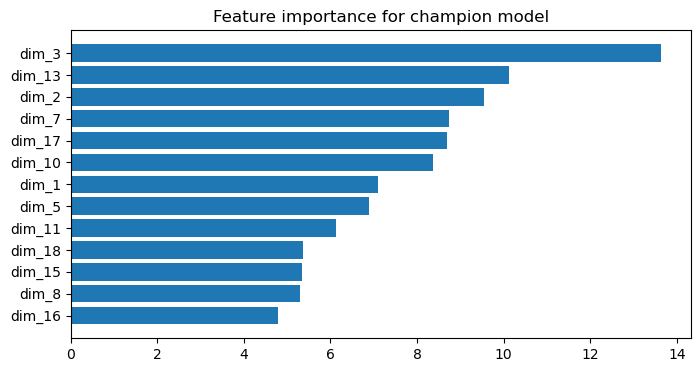

In [114]:
feature_importance = model.feature_importances_
sorted_indices = np.argsort(feature_importance)[::]
sorted_features = undropped_dimensions[sorted_indices]
sorted_importance = feature_importance[sorted_indices]

plt.figure(figsize=(8, 4))
plt.barh(sorted_features, sorted_importance)
plt.title(f'Feature importance for champion model')
plt.show()
